# Discrete Events Simulation - Queuing Theory

Priyank Venkatesh 14133830 \
Guoda Paulauskaite 12255076\
Koen Weverink 14711982

## Multiple queues and multiple servers


$\lambda$ – the arrival rate into the system as a whole. \
$\mu$ – the capacity of each of n equal servers. \
$\rho$ represents the system load. \
In a single server system, it will be: $\rho = \frac{\lambda}{\mu}$ \
In a multi-server system (one queue with n equal servers, each with capacity $\mu$), it will be $\rho = \frac{\lambda}{(n \mu)}$

Queuing theory tells us that for FIFO scheduling the average waiting times are shorter for an
M/M/n queue and a system load ρ and processor capacity µ than for a single M/M/1 queue
with the same load characteristics (and thus an n-fold lower arrival rate). Of course, ρ must be
less than one, but the experiment only becomes interesting when ρ is not much less than one.

### 1) Look up and/or derive this theoretical result, at least for n=2. Describe how it is derived. Can you also give a non-mathematical explanation?

See report

### 2) Write a DES program to verify this for n=1, n=2 and n=4. Make sure that your result has a high and known statistical significance. How does the number of measurements required to attain this depend on ρ?

In [1]:
import numpy as np
import simpy
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.stats import t
import pandas as pd

In [2]:
def hyperexponential_2_phases(p_values = [0.75, 0.25], means = [1, 5]):
    '''Generates a single sample from a hyperexponential distribution.
    Input: p_values, list with probabilities for every phase, and means, list of means for every phase.
    Output: single sample from the hyperexponential distribution.
    '''
    if sum(p_values) != 1.0:
        raise ValueError("Probabilities must add up to 1!")
    
    choice_idx = np.random.choice(len(p_values), p=p_values)
    mean = means[choice_idx]
    
    return np.random.exponential(mean)

In [3]:
class MMNQueue:
    def __init__(self, env, n, rho, mu, scheduling='FIFO', service_distr = 'M'):
        """
        Initializes the MMNQueue object.

        Parameters:
        - env: SimPy environment
        - n: Number of servers in the system
        - rho: Traffic intensity (ratio of arrival rate to service rate per server)
        - mu: Service rate per server
        - scheduling: Scheduling method for servers ('FIFO' or 'SJF')
        - service_distr: Service time distribution ('M', 'D', or 'H2')
        """

        self.env = env
        self.server_fifo = simpy.Resource(env, capacity=n)
        self.servers_sjf = simpy.PriorityResource(env, capacity=n)
        self.mu = mu
        self.rho = rho
        self.lamda = rho*(n*mu)
        self.total_arrivals = 0
        self.total_complete_services = 0
        self.total_time_in_queue = 0
        self.arrival_times = []
        self.scheduling = scheduling
        self.service_distr = service_distr

    def arrival_process(self, num_customers):
        """
        Simulates the arrival process of customers.

        Parameters:
        - num_customers: Total number of customers to be served
        """

        while self.total_arrivals < num_customers:
            yield self.env.timeout(np.random.exponential(1 / self.lamda))
            self.total_arrivals += 1
            arrival_time = self.env.now
            self.arrival_times.append(arrival_time)
            self.env.process(self.service())

    def service(self):
        """
        Simulates the service process for a customer.
        """
    
        arrival_time = self.env.now

        if self.scheduling == 'FIFO':
            server = self.server_fifo
        elif self.scheduling == 'SJF':
            server = self.servers_sjf
        else:
            raise ValueError("Invalid Scheduling Method")

        with server.request(priority=np.random.exponential(1 / self.mu)) if self.scheduling == 'SJF' else server.request() as req:
            yield req
            
            service_start_time = self.env.now

            if self.service_distr == 'M':
                service_time = np.random.exponential(1 / self.mu)
            elif self.service_distr == 'D':
                service_time = 1 / self.mu
            elif self.service_distr == 'H2':
                service_time = hyperexponential_2_phases()
            else:
                raise ValueError("Invalid Service Time Distribution")

            yield self.env.timeout(service_time)

            self.total_complete_services += 1

            # Calculate time spent in the queue
            time_in_queue = service_start_time - arrival_time
            self.total_time_in_queue += time_in_queue

    def run_simulation(self, num_customers):
        """
        Runs the simulation for a specified number of customers.

        Parameters:
        - num_customers: Total number of customers to be served in the simulation
        """
        self.env.process(self.arrival_process(num_customers))
        self.env.run(until=float('inf')) 

In [4]:
def calculate_confidence_interval(data, confidence=0.95):
    """
    Calculate a confidence interval for a given dataset.

    Parameters:
    - data: List or array-like object containing the data points
    - confidence: Desired confidence level for the interval (default is 0.95)

    Returns:
    - Tuple containing the mean of the data and the lower and upper bounds
      of the confidence interval.
    """
    n = len(data)
    m, se = np.mean(data), np.std(data, ddof=1) / np.sqrt(n)
    h = se * t.ppf((1 + confidence) / 2, n - 1)
    return m, (m - h, m + h)

<ipython-input-5-aae7a12777ee>:89: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2, 3, i)
<ipython-input-5-aae7a12777ee>:102: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2, 3, i + 3)
<ipython-input-5-aae7a12777ee>:89: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created 

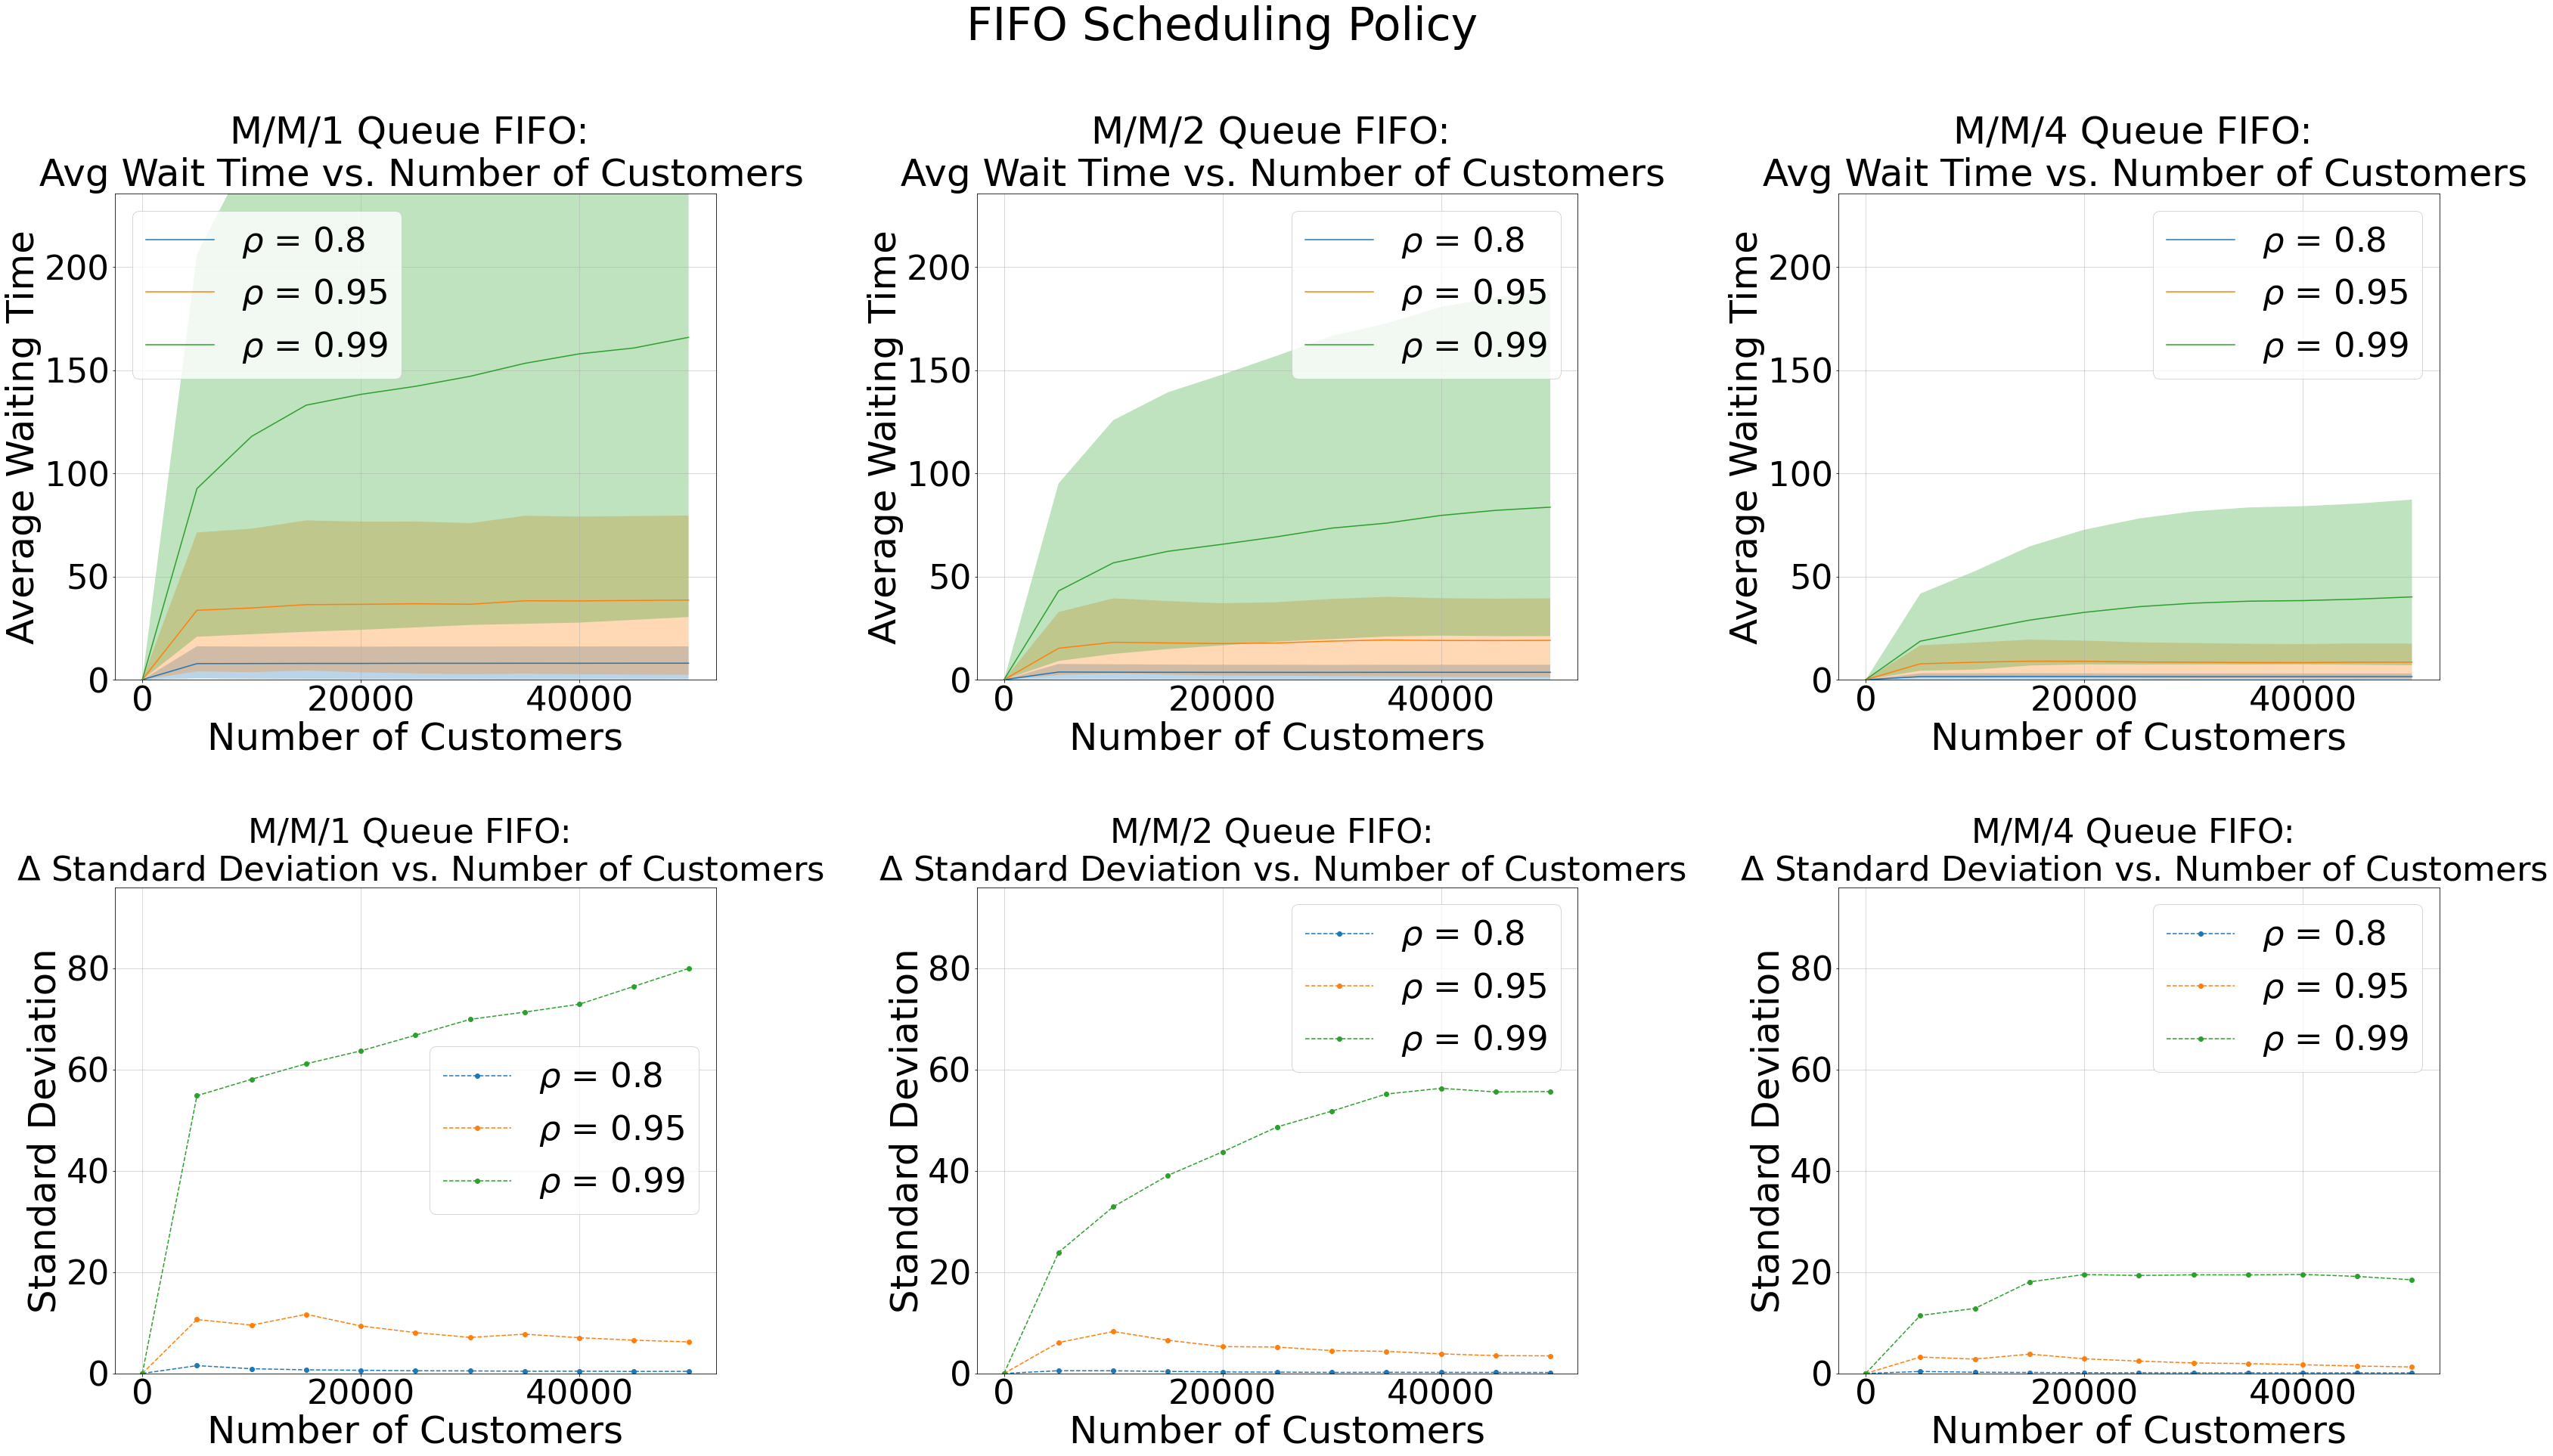

<ipython-input-5-aae7a12777ee>:89: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2, 3, i)
<ipython-input-5-aae7a12777ee>:102: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2, 3, i + 3)
<ipython-input-5-aae7a12777ee>:89: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created 

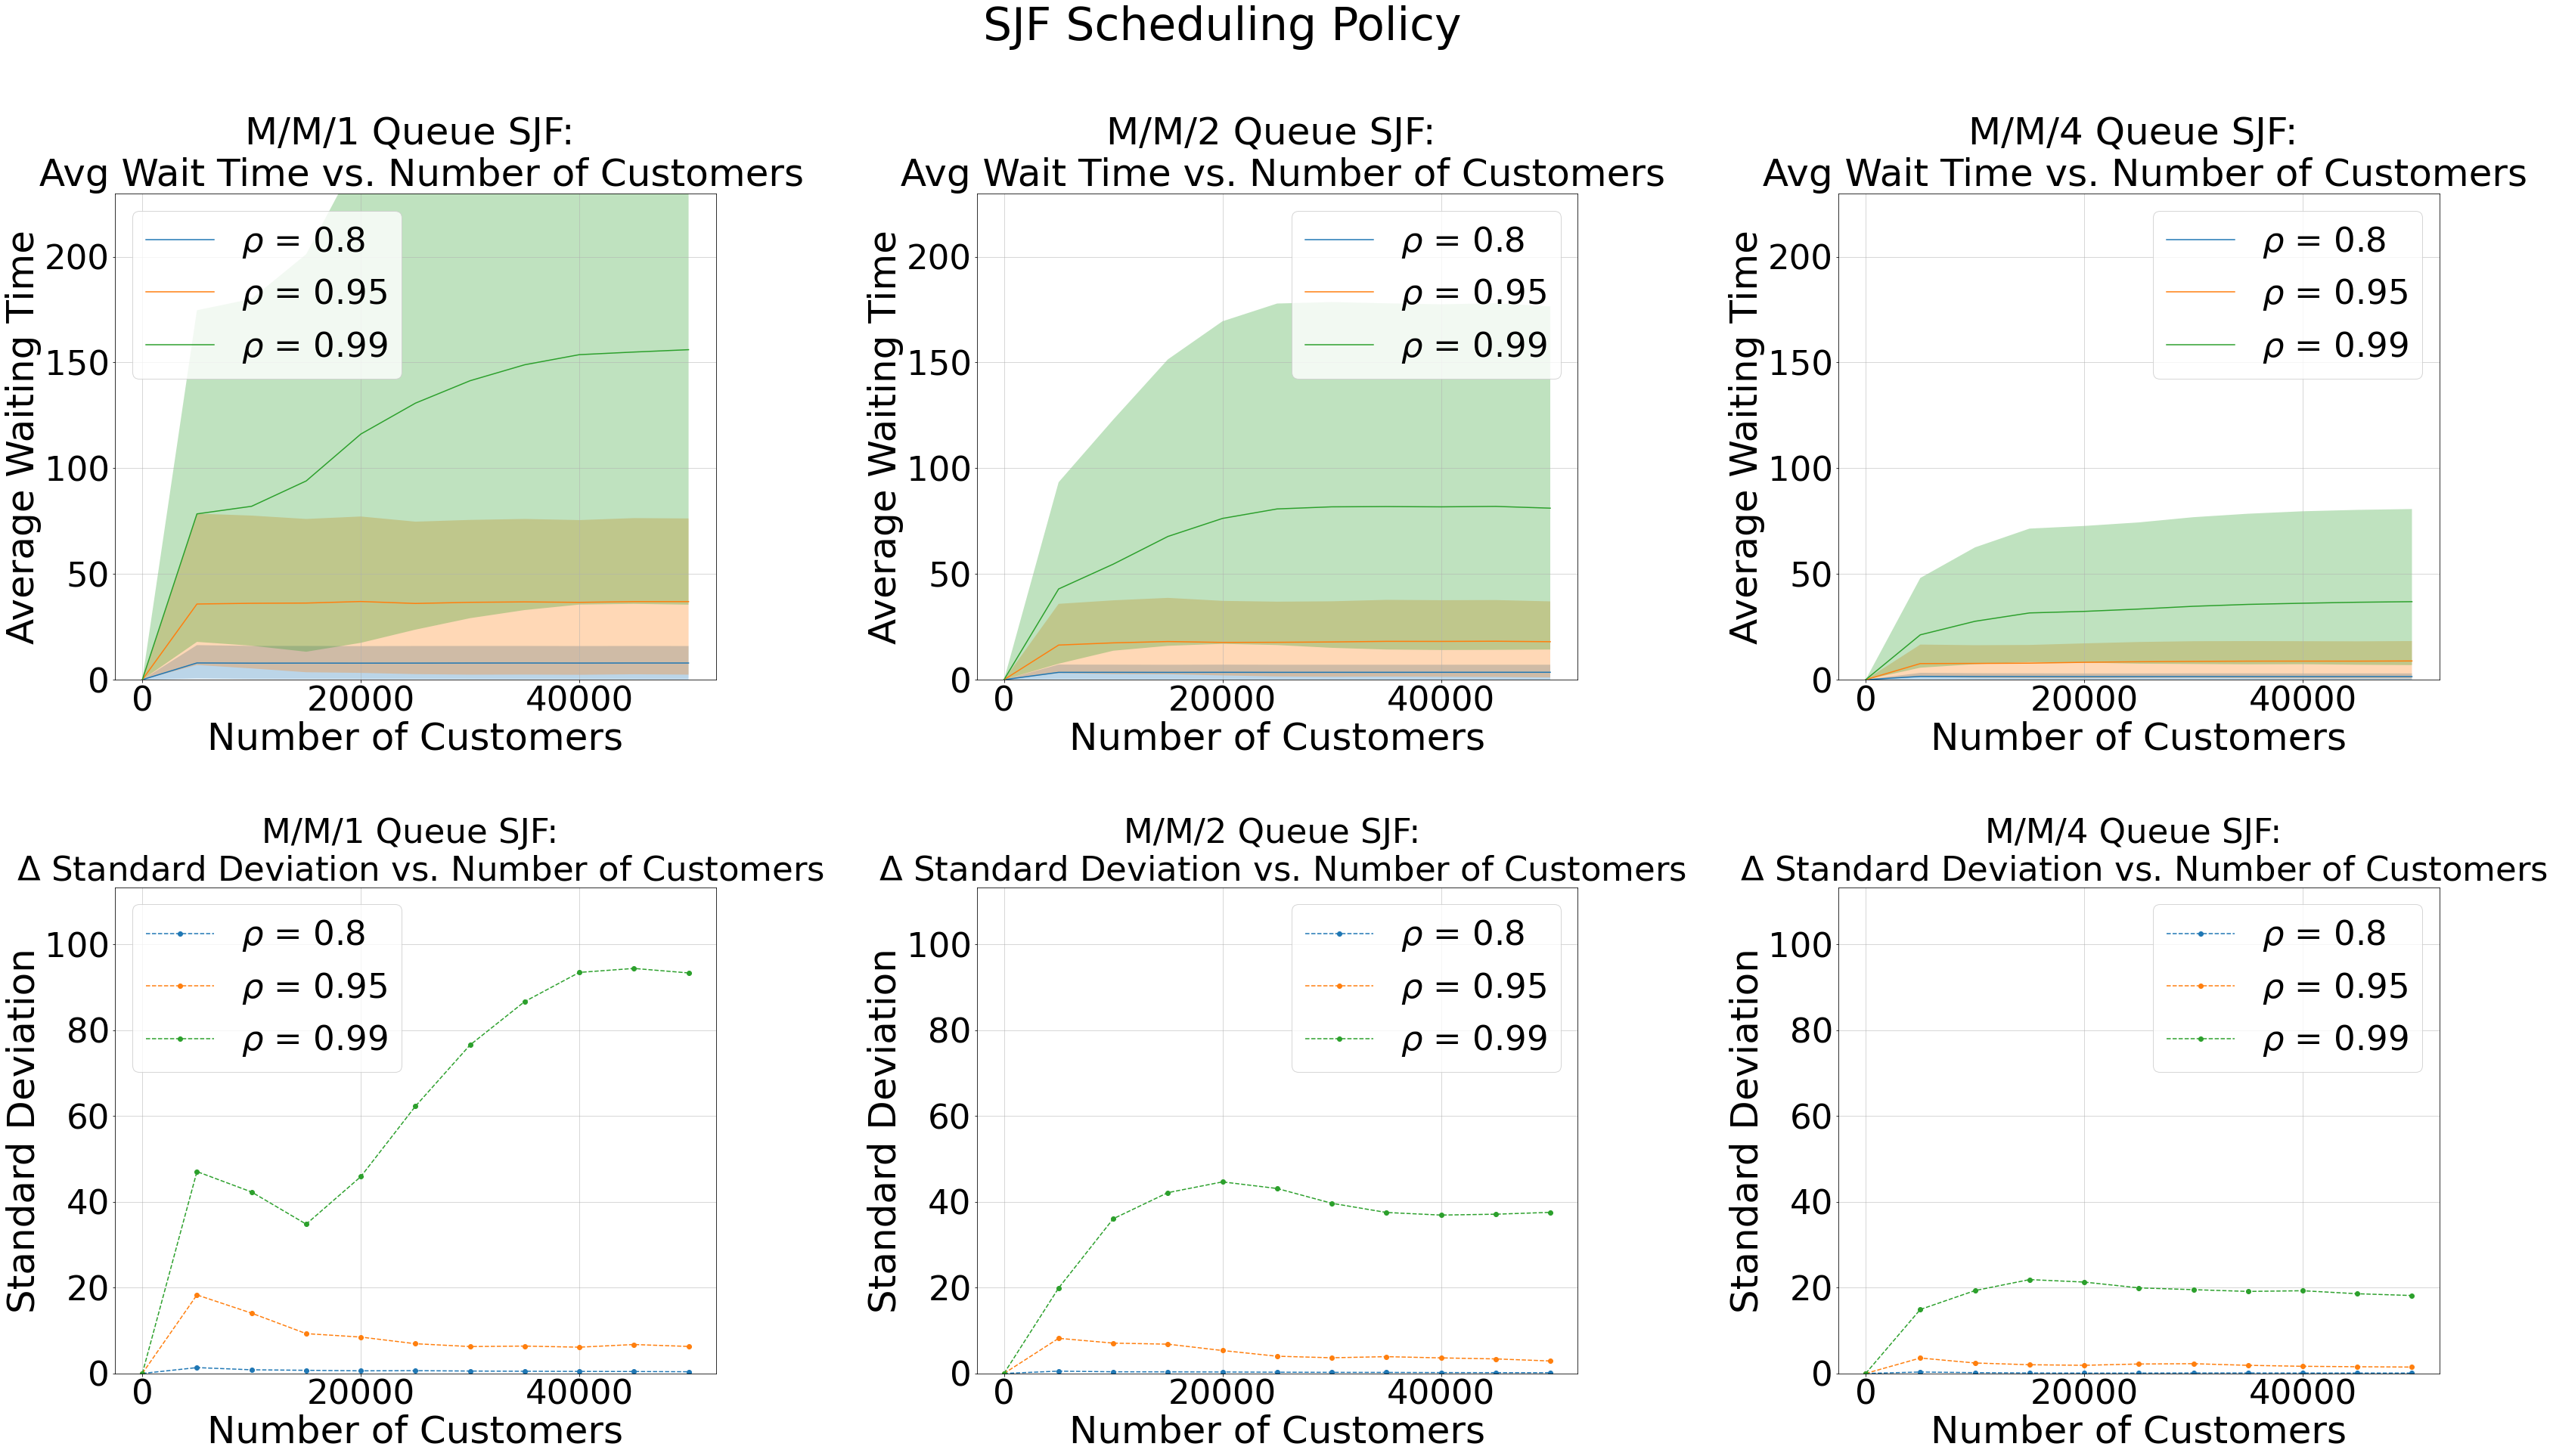

In [5]:
def main():
    """
    Run simulations for the M/M/n queue with different scheduling policies and plot the results.

    Returns:
    - DataFrame containing simulation results.
    """

    num_simulations = 30
    num_customers_values = np.arange(0, 50001, 5000)
    rhos = [0.8, 0.95, 0.99]
    mu = 1 / 2
    scheduling_policies = ['FIFO', 'SJF']

    results_df = pd.DataFrame(columns=['Scheduling Policy', 'n', 'rho', 'Num Customers', 'Avg Waiting Time', 'Confidence Interval', 'Std', 'Mean'])

    for scheduling_policy in scheduling_policies:
        plt.figure(figsize=(45, 30))
        plt.suptitle(f'{scheduling_policy} Scheduling Policy', fontsize=60)

        # Initialize variables to track maximum values
        max_avg_waiting_time = 0
        max_std_value = 0

        for i, n in enumerate([1, 2, 4], start=1):
            plt.subplot(2, 3, i)  # Plot average waiting time
            plt.grid(True)
            plt.title(f'M/M/{n} Queue {scheduling_policy}: \n Avg Wait Time vs. Number of Customers', fontsize=50)
            plt.xlabel('Number of Customers', fontsize=50)
            plt.ylabel('Average Waiting Time', fontsize=50)

            plt.subplot(2, 3, i + 3)  # Plot standard deviation
            plt.grid(True)
            plt.title(f'M/M/{n} Queue {scheduling_policy}: \n $\Delta$ Standard Deviation vs. Number of Customers', fontsize=45)
            plt.xlabel('Number of Customers', fontsize=50)
            plt.ylabel('Standard Deviation', fontsize=50)

            # Initialize arrays to store results
            num_customers_values_all = []
            avg_waiting_times_all = []
            confidence_intervals_all = []
            std_values_all = []
            mean_values_all = []

            for rho in rhos:
                avg_waiting_times = []
                confidence_intervals = []
                std_values = []

                for num_customers in num_customers_values:
                    simulation_results = []

                    for num in range(num_simulations):
                        np.random.seed(num)
                        env = simpy.Environment()
                        mmn_queue = MMNQueue(env, n, rho, mu, scheduling_policy)
                        mmn_queue.run_simulation(num_customers)

                        if mmn_queue.total_complete_services > 0:
                            avg_waiting_time_one_sim = mmn_queue.total_time_in_queue / mmn_queue.total_complete_services
                            simulation_results.append(avg_waiting_time_one_sim)
                        else:
                            simulation_results.append(0)

                    avg_waiting_time_over_sims, confidence_interval = calculate_confidence_interval(simulation_results)
                    avg_waiting_times.append(avg_waiting_time_over_sims)
                    confidence_intervals.append(confidence_interval)

                    std_value = np.std(simulation_results)
                    std_values.append(std_value)

                # Update maximum values
                max_avg_waiting_time = max(max_avg_waiting_time, max(avg_waiting_times + [interval[1] for interval in confidence_intervals]))
                max_std_value = max(max_std_value, max(std_values))

                # Append results to arrays
                num_customers_values_all.extend(num_customers_values)
                avg_waiting_times_all.extend(avg_waiting_times)
                confidence_intervals_all.extend(confidence_intervals)
                std_values_all.extend(std_values)
                mean_values_all.extend([np.mean(simulation_results)] * len(num_customers_values))

            # Append results to the DataFrame
            results_df = pd.concat([results_df, pd.DataFrame({
                'Scheduling Policy': [scheduling_policy] * len(num_customers_values_all),
                'n': [n] * len(num_customers_values_all),
                'rho': np.repeat(rhos, len(num_customers_values)),
                'Num Customers': num_customers_values_all,
                'Avg Waiting Time': avg_waiting_times_all,
                'Confidence Interval': confidence_intervals_all,
                'Std': std_values_all,
                'Mean': mean_values_all
            })], ignore_index=True)

            # Plot the average waiting time with confidence intervals
            plt.subplot(2, 3, i)
            for j, rho in enumerate(rhos):
                lower_bound = [avg - interval[0] for avg, interval in zip(avg_waiting_times_all[j * len(num_customers_values):(j + 1) * len(num_customers_values)], confidence_intervals_all[j * len(num_customers_values):(j + 1) * len(num_customers_values)])]
                upper_bound = [avg + interval[1] for avg, interval in zip(avg_waiting_times_all[j * len(num_customers_values):(j + 1) * len(num_customers_values)], confidence_intervals_all[j * len(num_customers_values):(j + 1) * len(num_customers_values)])]
                plt.plot(num_customers_values, avg_waiting_times_all[j * len(num_customers_values):(j + 1) * len(num_customers_values)],
                         label=f'$\\rho$ = {rho}')
                plt.fill_between(num_customers_values, lower_bound, upper_bound, alpha=0.3)
            plt.legend(fontsize=45)  # Add legend with 'rho'
            plt.tick_params(axis='both', which='both', labelsize=45)
            plt.grid(True, linewidth=0.5)
            plt.ylim(0, max_avg_waiting_time * 1.2)  # Set y-axis range

            # Plot the standard deviation
            plt.subplot(2, 3, i + 3)
            for j, rho in enumerate(rhos):
                plt.plot(num_customers_values, std_values_all[j * len(num_customers_values):(j + 1) * len(num_customers_values)],
                         linestyle='--', marker='o', label=f'$\\rho$ = {rho}')
            plt.legend(fontsize=45)  # Add legend with 'rho'
            plt.tick_params(axis='both', which='both', labelsize=45)
            plt.grid(True, linewidth=0.5)
            plt.ylim(0, max_std_value * 1.2)  # Set y-axis range

        plt.tight_layout(rect=[0, 0.09, 1, 0.95], h_pad=8.0, w_pad=20.0)  # Adjust the layout with added vertical space
        plt.savefig(f'output_{scheduling_policy}.png', dpi=300, bbox_inches='tight')  # Save the plot as a PNG file
        plt.show()

    
    results_df = results_df.round({'Avg Waiting Time': 5, 'Std': 5, 'Mean': 5})
    results_df['Confidence Interval'] = results_df['Confidence Interval'].apply(lambda x: tuple(round(val, 5) for val in x))

    return results_df


if __name__ == "__main__":
    results = main()
    csv_path = 'FIFO_SJF_data2.csv'
    results.to_csv(csv_path, index=False)

# n = 1 vs n = 2 vs n=4

In [6]:
#Statistical tests: Welch test for two samples
# Compare different queue numbers (for different rhos)
rhos = [0.8, 0.95, 0.99]

# Table header
print('FIFO')
print("{:<10} {:<20} {:<20} {:<20}".format("Rho", "E(M/M/1) > E(M/M/2)", "E(M/M/2) > E(M/M/4)", "E(M/M/1) > E(M/M/4)"))

for rho in rhos:
    FIFO_n1 = results[
        (results['Scheduling Policy'] == 'FIFO') &
        (results['n'] == 1) &
        (results['rho'] == rho)
    ]['Avg Waiting Time'].values

    FIFO_n2 = results[
        (results['Scheduling Policy'] == 'FIFO') &
        (results['n'] == 2) &
        (results['rho'] == rho)
    ]['Avg Waiting Time'].values

    FIFO_n4 = results[
        (results['Scheduling Policy'] == 'FIFO') &
        (results['n'] == 4) &
        (results['rho'] == rho)
    ]['Avg Waiting Time'].values

    _, p_value_1_vs_2 = ttest_ind(FIFO_n1, FIFO_n2, equal_var = False, alternative = 'greater')
    _, p_value_2_vs_4 = ttest_ind(FIFO_n2, FIFO_n4, equal_var = False, alternative = 'greater')
    _, p_value_1_vs_4 = ttest_ind(FIFO_n1, FIFO_n4, equal_var = False, alternative = 'greater')
    print("{:<10} {:<20.2e} {:<20.2e} {:<20.2e}".format(rho, p_value_2_vs_4, p_value_1_vs_2, p_value_1_vs_4))
   

FIFO
Rho        E(M/M/1) > E(M/M/2)  E(M/M/2) > E(M/M/4)  E(M/M/1) > E(M/M/4) 
0.8        5.86e-05             1.04e-04             4.04e-06            
0.95       1.56e-04             2.25e-04             6.37e-06            
0.99       5.73e-04             5.15e-04             1.62e-05            


# SJF vs. FIFO

In [7]:
# Statistical tests: Welch test for two samples
# Compare SJF with FIFO for different n values
rhos = [0.8, 0.95, 0.99]
n_values = [1, 2, 4]

# Table header
print("{:<10} {:<30} {:<30} {:<30}".format("Rho", "E(M/M/1 FIFO) > E(M/M/1 SJF)", "E(M/M/2 FIFO) > E(M/M/2 SJF)", "E(M/M/4 FIFO) > E(M/M/4 SJF)"))

#Compare M/M/1 FIFO vs. SJF
for rho in rhos:
    print("{:<10}".format(rho), end=" ")

    for n in n_values:
        FIFO_res = results[
            (results['Scheduling Policy'] == 'FIFO') &
            (results['n'] == n) &
            (results['rho'] == rho)
        ]['Avg Waiting Time'].values
            
        SJF_res = results[
            (results['Scheduling Policy'] == 'SJF') &
            (results['n'] == n) &
            (results['rho'] == rho)
        ]['Avg Waiting Time'].values
        
        _, p_value = ttest_ind(FIFO_res, SJF_res, equal_var = False, alternative = 'greater')
        print("{:<30.2e}".format(p_value), end=" ")

    print()

Rho        E(M/M/1 FIFO) vs E(M/M/1 SJF)  E(M/M/2 FIFO) vs E(M/M/2 SJF)  E(M/M/4 FIFO) vs E(M/M/4 SJF) 
0.8        4.80e-01                       4.16e-01                       4.61e-01                       
0.95       4.76e-01                       4.38e-01                       4.67e-01                       
0.99       2.51e-01                       6.30e-01                       4.57e-01                       


# Different Service Rate distributions

<ipython-input-8-e685ef581517>:73: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2, 3, i)
<ipython-input-8-e685ef581517>:85: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2, 3, i + 3)
<ipython-input-8-e685ef581517>:73: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created a

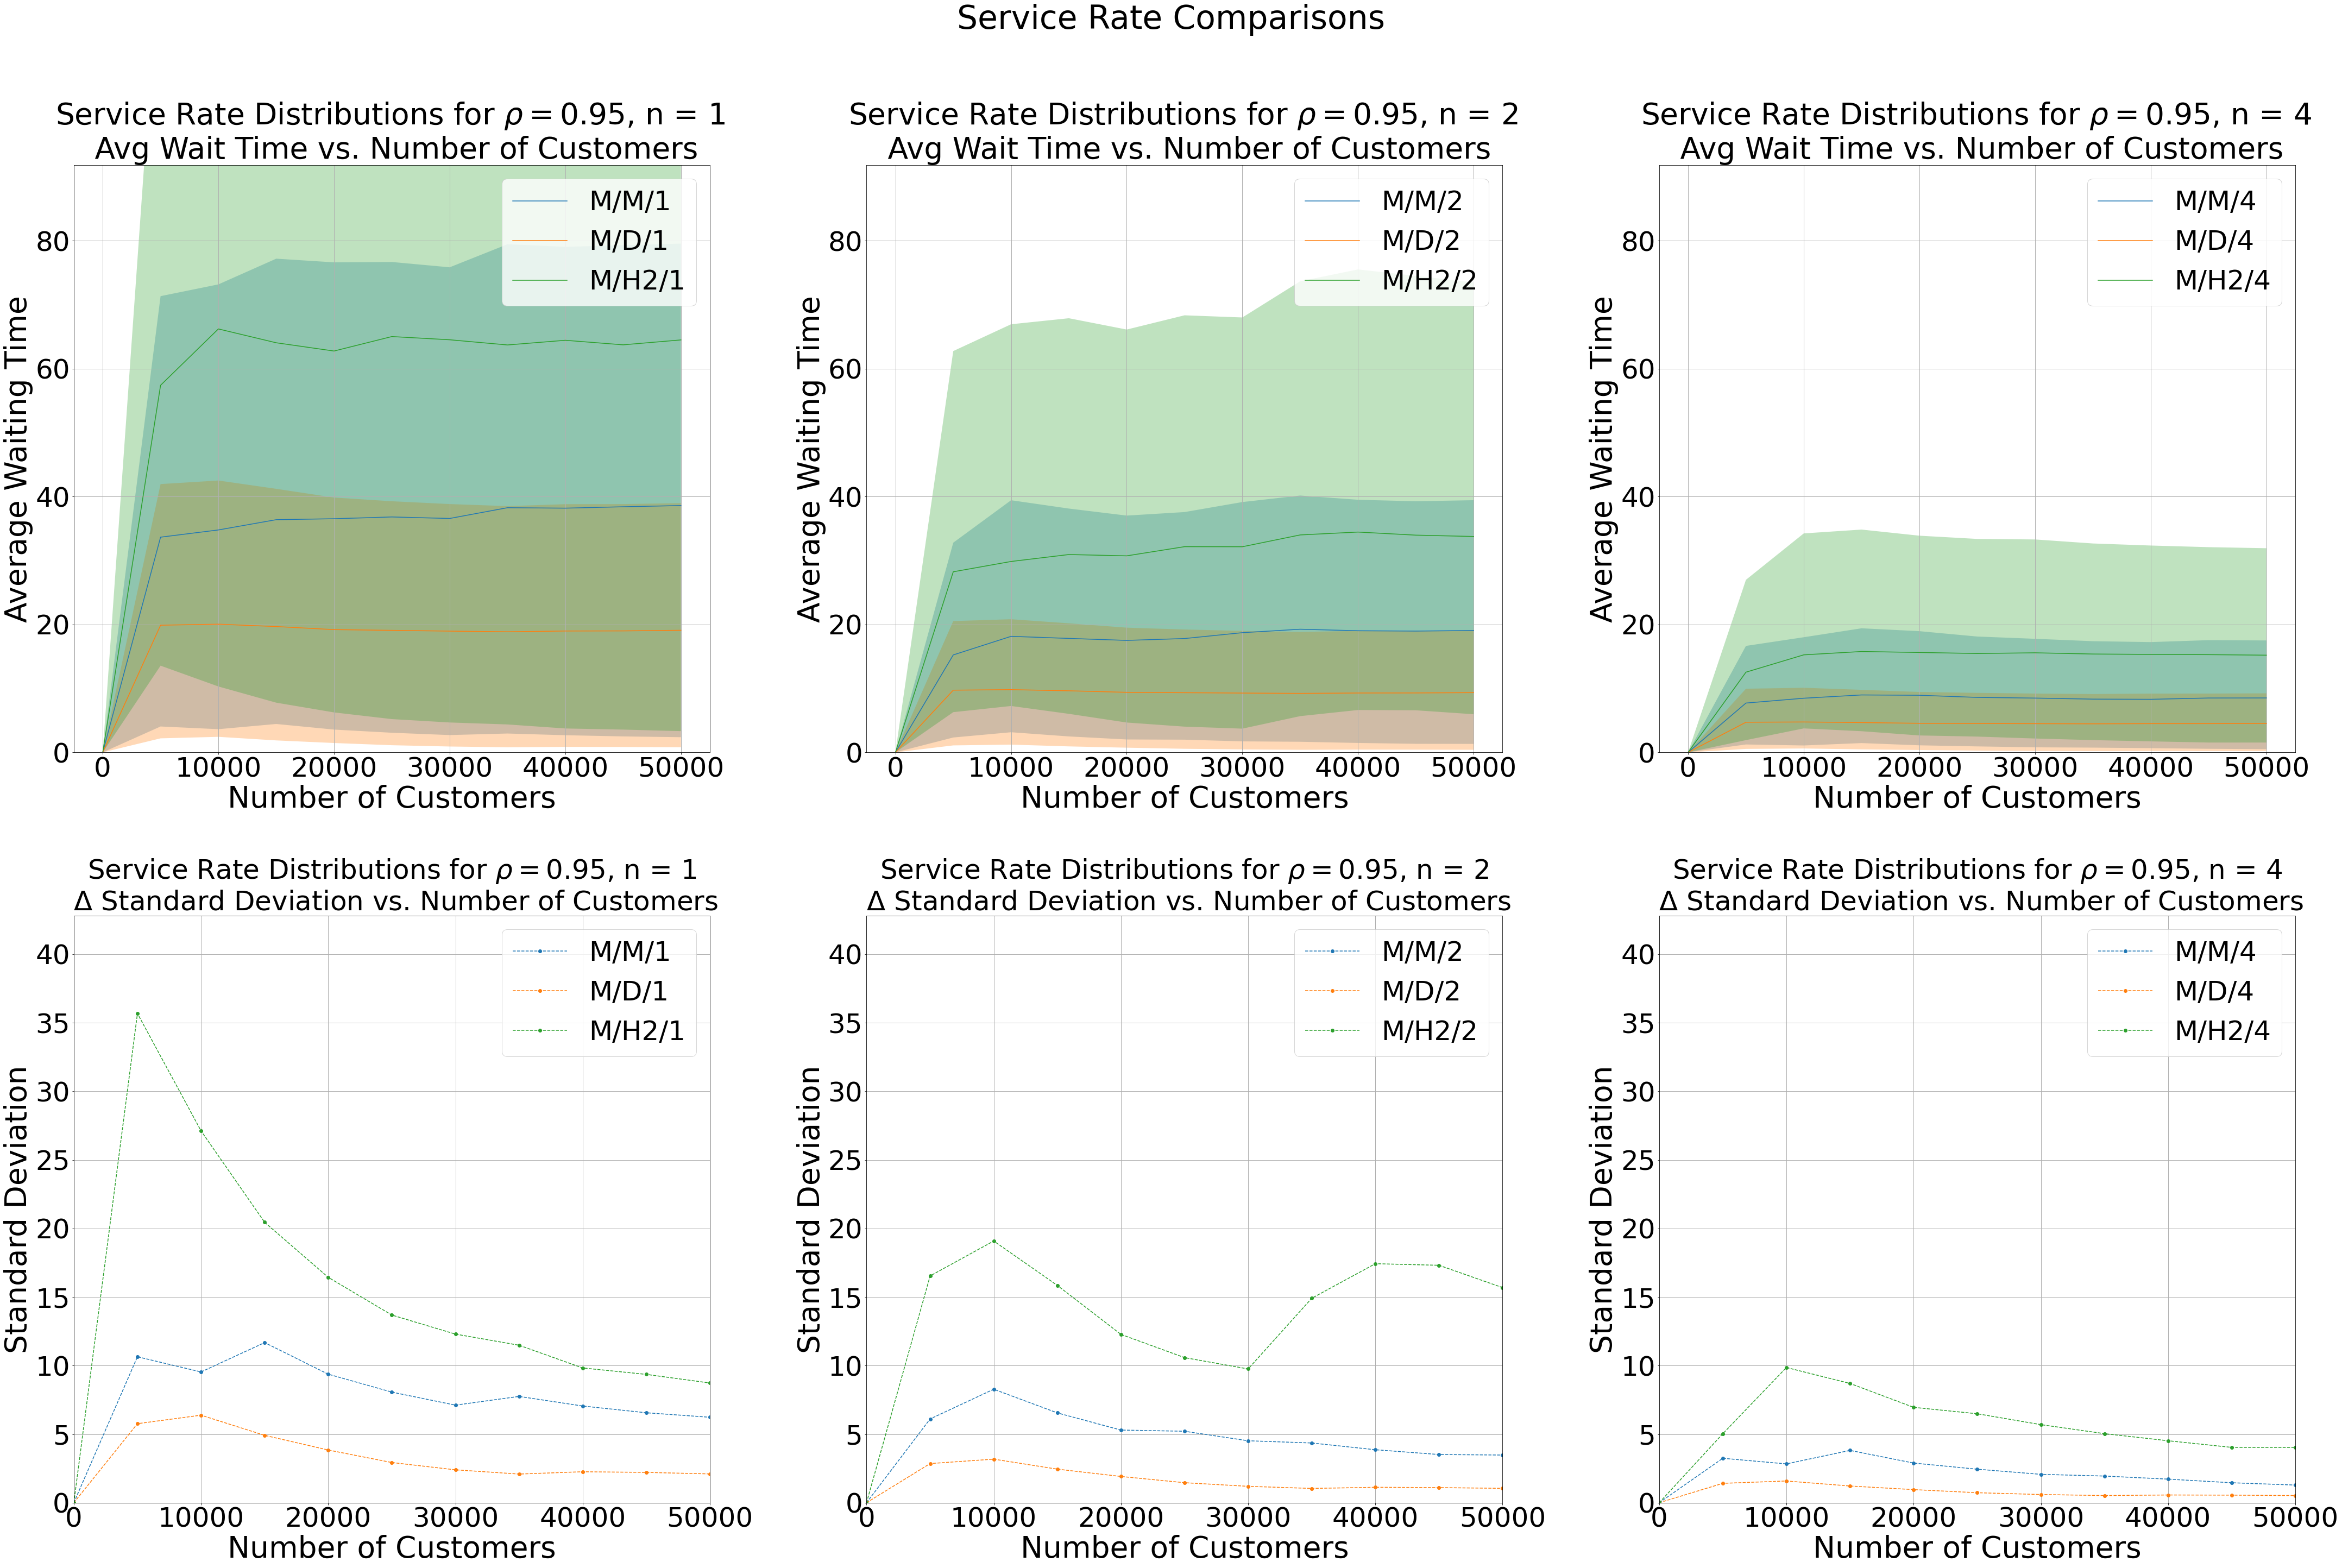

In [8]:
def service_rate_comparisons():
    """
    Perform simulations to compare the impact of different service rate distributions on the M/M/n queue.

    Returns:
    - DataFrame containing simulation results.
    """
    
    num_simulations = 30
    num_customers_values = np.arange(0, 50001, 5000)
    rho = 0.95
    mu = 1 / 2
    service_distributions = ['M', 'D', 'H2']  # Exponential, Deterministic, Hyper-2

    # Store results in DF
    results_df2 = pd.DataFrame(
        columns=['Service Distribution', 'n', 'Num Customers', 'Avg Waiting Time', 'Confidence Interval', 'Std', 'Mean'])

    plt.figure(figsize=(60, 45))
    plt.suptitle(f'Service Rate Comparisons', fontsize=60)

    max_avg_waiting_time = 0
    max_std_value = 0

    for i, n in enumerate([1, 2, 4], start=1):
        plt.subplot(2, 3, i)  # Plot average waiting time
        plt.grid(True)
        plt.title(f'Service Rate Distributions for $\\rho = {rho}$, n = {n} \n Avg Wait Time vs. Number of Customers', fontsize=55)
        plt.xlabel('Number of Customers', fontsize=55)
        plt.ylabel('Average Waiting Time', fontsize=55)

        plt.subplot(2, 3, i + 3)  # Plot standard deviation
        plt.grid(True)
        plt.title(f'Service Rate Distributions for $\\rho = {rho}$, n = {n}\n $\Delta$ Standard Deviation vs. Number of Customers', fontsize=50)
        plt.xlabel('Number of Customers', fontsize=55)
        plt.ylabel('Standard Deviation', fontsize=55)

        for service_distr in service_distributions:
            avg_waiting_times = []
            confidence_intervals = []
            std_values = []

            for num_customers in num_customers_values:
                simulation_results = []

                for num in range(num_simulations):
                    np.random.seed(num)
                    env = simpy.Environment()
                    mmn_queue = MMNQueue(env, n, rho, mu, service_distr=service_distr)
                    mmn_queue.run_simulation(num_customers)

                    if mmn_queue.total_complete_services > 0:
                        avg_waiting_time_one_sim = mmn_queue.total_time_in_queue / mmn_queue.total_complete_services
                        simulation_results.append(avg_waiting_time_one_sim)
                    else:
                        simulation_results.append(0)

                avg_waiting_time_over_sims, confidence_interval = calculate_confidence_interval(simulation_results)
                avg_waiting_times.append(avg_waiting_time_over_sims)
                confidence_intervals.append(confidence_interval)

                std_value = np.std(simulation_results)
                std_values.append(std_value)

            # Update maximum values
            max_avg_waiting_time = max(max_avg_waiting_time, max(avg_waiting_times + [interval[1] for interval in confidence_intervals]))
            max_std_value = max(max_std_value, max(std_values))

            results_df2 = pd.concat([results_df2, pd.DataFrame({
                'Service Distribution': [service_distr] * len(num_customers_values),
                'n': [n] * len(num_customers_values),
                'Num Customers': num_customers_values,
                'Avg Waiting Time': avg_waiting_times,
                'Confidence Interval': confidence_intervals,
                'Std': std_values,
                'Mean': [np.mean(simulation_results)] * len(num_customers_values)
            })], ignore_index=True)

            # Plot the average waiting time with confidence intervals
            plt.subplot(2, 3, i)
            plt.plot(num_customers_values, avg_waiting_times, label=f'M/{service_distr}/{n}')
            plt.fill_between(num_customers_values,
                             np.array(avg_waiting_times) - np.array(confidence_intervals)[:, 0],
                             np.array(avg_waiting_times) + np.array(confidence_intervals)[:, 1],
                             alpha=0.3)
            plt.legend(fontsize=50)
            plt.tick_params(axis='both', which='both', labelsize=50)
            plt.grid(True, linewidth=1)
            plt.ylim(0, max_avg_waiting_time * 1.2)  # Set y-axis range

            # Plot the standard deviation
            plt.subplot(2, 3, i + 3)
            plt.plot(num_customers_values, std_values, linestyle='--', marker='o', label=f'M/{service_distr}/{n}')
            plt.legend(fontsize=50)
            plt.tick_params(axis='both', which='both', labelsize=50)
            plt.grid(True, linewidth=1)
            plt.ylim(0, max_std_value * 1.2)  # Set y-axis range
            plt.xlim(min(num_customers_values), max(num_customers_values))

    plt.tight_layout(rect=[0, 0.09, 1, 0.95], h_pad=8.0, w_pad=8.0)
    plt.savefig(f'output_service_rate_comparisons5.png', dpi=300, bbox_inches='tight')
    plt.show()

    results_df2 = results_df2.round({'Avg Waiting Time': 5, 'Std': 5, 'Mean': 5})
    results_df2['Confidence Interval'] = results_df2['Confidence Interval'].apply(
        lambda x: tuple(round(val, 5) for val in x))

    return results_df2

results2 = service_rate_comparisons()
csv_path2 = 'service_distributions_data5.csv'
results2.to_csv(csv_path2, index=False)

# M/M/n vs M/D/n vs M/h2/n

In [9]:
# Statistical tests: Welch test for two samples
# Compare different service rate distributions (for different queue numbers)
ns = [1, 2, 4]

# Table header
print("{:<10} {:<25} {:<25} {:<25}".format("n", "E(M/M/n) > E(M/D/n)", "E(M/D/n) vs E(M/H2/n)","E(M/M/n) vs E(M/H2/n)"))

#Compare M/M/n vs M/D/n vs M/h2/n
for n in ns:
    M_M_n = results2[
        (results2['Service Distribution'] == 'M') &
        (results2['n'] == n)
    ]['Avg Waiting Time'].values
        
    M_D_n = results2[
        (results2['Service Distribution'] == 'D') &
        (results2['n'] == 1)
    ]['Avg Waiting Time'].values

    M_H2_n = results2[
        (results2['Service Distribution'] == 'H2') &
        (results2['n'] == 1)
    ]['Avg Waiting Time'].values
        
    _, p_value_MD = ttest_ind(M_M_n, M_D_n, equal_var = False, alternative = 'greater')
    _, p_value_DH2 = ttest_ind(M_D_n, M_H2_n, equal_var = False)
    _, p_value_MH2 = ttest_ind(M_M_n, M_H2_n, equal_var = False)

    print("{:<10} {:<25.2e} {:<25.2e} {:<25.2e}".format(n, p_value_MD, p_value_DH2, p_value_MH2))


n          E(M/M/n) > E(M/D/n)       E(M/D/n) vs E(M/H2/n)     E(M/M/n) vs E(M/H2/n)    
1          3.95e-04                  2.64e-05                  2.29e-03                 
2          6.60e-01                  2.64e-05                  2.14e-05                 
4          1.00e+00                  2.64e-05                  5.28e-06                 
